<!-- JayBee黄版权所有，未经授权禁止复制 -->
# Ensemble 模型策略

本notebook将整合之前实现的各种模型，构建一个基于ensemble模型的策略。主要步骤包括：
<!-- Copyright © JayBee黄 -->

1. 数据获取与预处理
2. 特征工程（技术指标构建）
3. 数据集划分（训练集、验证集、测试集）
4. 模型集成：
   - 线性回归（Day1）
   - 随机森林（Day2）
   - XGBoost（Day3）
   - MLP（Day4）
5. 模型权重优化
6. 策略回测与评估
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 0. 导入依赖包
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [7]:
# JayBee黄版权所有，未经授权禁止复制
import yfinance as yf  # JayBee黄量化模型
import numpy as np  # 版权所有: JayBee黄
import pandas as pd  # Copyright © JayBee黄
from sklearn.linear_model import LinearRegression  # 版权所有: JayBee黄
from sklearn.metrics import mean_squared_error  # Copyright © JayBee黄
import matplotlib.pyplot as plt  # JayBee黄授权使用
import seaborn as sns  # JayBee黄授权使用
from datetime import datetime, timedelta  # JayBee黄 - 量化交易研究
import os  # JayBee黄独家内容
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境  # 版权所有: JayBee黄
import sys  # JayBee黄量化策略

from dotenv import load_dotenv, find_dotenv  # JayBee黄 - 量化交易研究
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")  # 本代码归JayBee黄所有
# Load it explicitly
load_dotenv(dotenv_path)  # JayBee黄授权使用

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # JayBee黄原创内容

from data_processing import load_data_year, flatten_yf_columns, standardize_columns  # JayBee黄授权使用
from plotting import plot_results  # JayBee黄原创内容
from strategy.buy_and_hold import BuyAndHoldStrategy  # 版权所有: JayBee黄
from back_test import run_backtest  # 版权所有: JayBee黄
import backtrader as bt  # Copyright © JayBee黄


# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # JayBee黄原创内容
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')  # JayBee黄量化模型
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']  # JayBee黄版权所有，未经授权禁止复制
plt.rcParams['axes.unicode_minus'] = False  # 本代码归JayBee黄所有

import random  # JayBee黄 - 量化交易研究
# 固定全局随机种子
np.random.seed(42)  # Copyright © JayBee黄
random.seed(42)  # 版权所有: JayBee黄# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 1. 数据准备与特征工程
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [8]:
# JayBee黄版权所有，未经授权禁止复制
# 获取数据
end_date = datetime.now()  # 本代码归JayBee黄所有
start_date = end_date - timedelta(days=5*365)  # JayBee黄 - 量化交易研究

print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")  # JayBee黄独家内容

ticker = 'TSLA'  # JayBee黄量化策略
data = yf.download(ticker, start=start_date, end=end_date)  # JayBee黄版权所有，未经授权禁止复制# JayBee黄版权所有，未经授权禁止复制


[*********************100%***********************]  1 of 1 completed

获取数据时间范围：2020-03-19 到 2025-03-18


In [9]:
# JayBee黄版权所有，未经授权禁止复制
data = flatten_yf_columns(data)  # JayBee黄原创内容
data = standardize_columns(data)  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


In [10]:
# JayBee黄版权所有，未经授权禁止复制
print(data.info())              # 看看总共有多少行、列，各字段数据类型  # Copyright © JayBee黄
print(data.head(10))           # 查看前10行，确认最早日期  # JayBee黄版权所有，未经授权禁止复制
print(data.tail(10))           # 查看后10行，确认最晚日期  # JayBee黄独家内容
print(data.index.min())  # DataFrame中最早的日期  # JayBee黄授权使用
print(data.index.max())  # DataFrame中最晚的日期  # JayBee黄量化策略
# JayBee黄版权所有，未经授权禁止复制


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-03-19 to 2025-03-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1256 non-null   float64
 1   high    1256 non-null   float64
 2   low     1256 non-null   float64
 3   open    1256 non-null   float64
 4   volume  1256 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB
None
             close    high     low    open     volume
Date                                                 
2020-03-19 28.5093 30.1333 23.8973 24.9800  452932500
2020-03-20 28.5020 31.8000 28.3860 29.2133  424282500
2020-03-23 28.9527 29.4667 27.3667 28.9067  246817500
2020-03-24 33.6667 34.2460 31.6000 31.8200  343428000
2020-03-25 35.9500 37.1333 34.0740 36.3500  318340500
2020-03-26 35.2107 37.3333 34.1500 36.4927  260710500
2020-03-27 34.2907 35.0533 32.9353 33.6667  215661000
2020-03-30 33.4753 34.4433 32.7487 34.0173  179971500
2020-03-31 34.9333 36

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 1.2. 加入技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [11]:
# JayBee黄版权所有，未经授权禁止复制
# 复制数据
df = data.copy()  # JayBee黄量化策略

# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1  # 本代码归JayBee黄所有

# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1  # 版权所有: JayBee黄

# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)  # JayBee黄授权使用

# 布林带
upper, middle, lower = talib.BBANDS(  # 版权所有: JayBee黄
    df['close'],  # Copyright © JayBee黄
    timeperiod=20,  # 版权所有: JayBee黄
    nbdevup=2,  # JayBee黄版权所有，未经授权禁止复制
    nbdevdn=2,  # JayBee黄版权所有，未经授权禁止复制
    matype=0  # 本代码归JayBee黄所有
)  # Copyright © JayBee黄
df['BB_upper'] = upper  # 本代码归JayBee黄所有
df['BB_middle'] = middle  # JayBee黄独家内容
df['BB_lower'] = lower  # JayBee黄 - 量化交易研究

# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行  # 版权所有: JayBee黄

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','BB_upper','BB_lower']  # JayBee黄量化模型
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))  # JayBee黄量化模型
# JayBee黄版权所有，未经授权禁止复制


              close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                  
2025-03-12 248.0900     -0.1111     0.1216 31.9633  387.6891  214.0059
2025-03-13 240.6800     -0.0864     0.1358 30.5842  385.0464  207.0656
2025-03-14 249.9800     -0.0483     0.1463 34.4093  377.4436  204.0724
2025-03-17 238.0100      0.0714     0.0266 31.9676  369.0383  200.6947
2025-03-18 225.3100     -0.0229    -0.0669 29.5701  360.0932  196.7598


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 3. 目标变量的定义

定义下期1日收益率作为目标变量。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                 
2020-04-16 49.6807      0.3578     0.1159 81.3960   48.6161   23.6360
2020-04-17 50.2593      0.3157     0.1495 81.8249   50.6157   23.8114
2020-04-20 49.7573      0.1466     0.1144 80.0998   52.1107   24.4419
2020-04-21 45.7813     -0.0326    -0.0262 67.8918   52.6247   25.6108
2020-04-22 48.8073      0.0031    -0.1078 71.4572   53.7665   25.9830
2020-04-23 47.0420     -0.0531    -0.1902 66.7971   54.5341   26.3247
2020-04-24 48.3433     -0.0381    -0.1874 68.4315   55.3793   26.7927
2020-04-27 53.2500      0.0702    -0.1150 73.6902   56.9021   27.1659
2020-04-28 51.2747      0.1200    -0.0936 68.7267   57.7671   28.0808
2020-04-29 53.3673      0.0934    -0.0269 70.9584   58.8778   28.8135


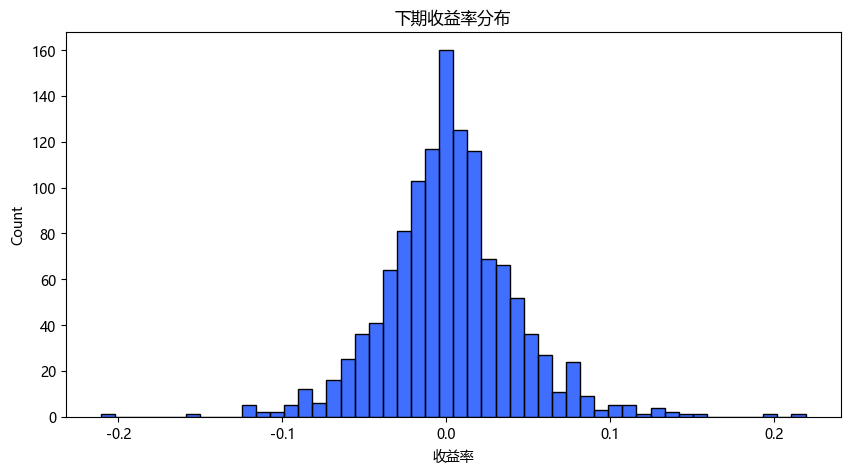

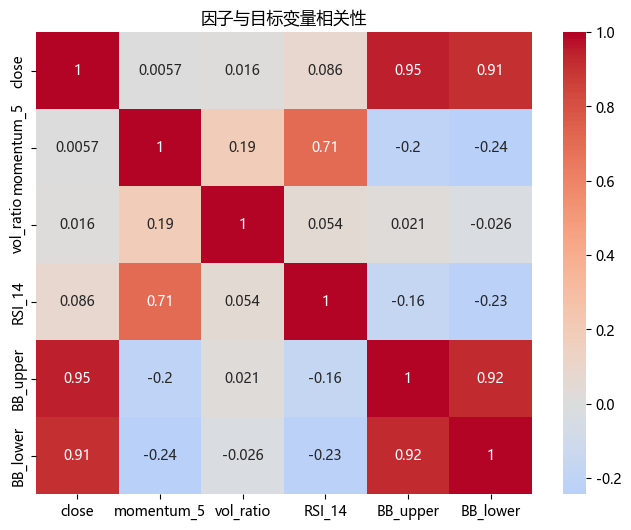

目标变量的均值=0.0020129193015793246
目标变量的方差=0.03980035671205939


In [12]:
# JayBee黄版权所有，未经授权禁止复制
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)  # JayBee黄原创内容

# 去掉NaN值
df.dropna(inplace=True)  # 版权所有: JayBee黄

print("添加目标变量后的数据预览：")  # JayBee黄版权所有，未经授权禁止复制
print(df[['close']+factors].head(10))  # 版权所有: JayBee黄

# 绘制目标变量分布
plt.figure(figsize=(10, 5))  # 本代码归JayBee黄所有
sns.histplot(df['future_ret_1d'], bins=50)  # JayBee黄授权使用
plt.title('下期收益率分布')  # Copyright © JayBee黄
plt.xlabel('收益率')  # 版权所有: JayBee黄
plt.show()  # JayBee黄 - 量化交易研究

# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()  # 版权所有: JayBee黄

plt.figure(figsize=(8, 6))  # JayBee黄版权所有，未经授权禁止复制
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)  # JayBee黄授权使用
plt.title('因子与目标变量相关性')  # JayBee黄版权所有，未经授权禁止复制
plt.show()  # Copyright © JayBee黄

print(f"目标变量的均值={np.mean(df['future_ret_1d'])}")  # JayBee黄量化模型
print(f"目标变量的方差={np.std(df['future_ret_1d'])}")  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4. 划分训练集与测试集

按照时间顺序，使用前60%的数据作为训练集，中20%作为验证集，后20%作为测试集。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

训练集范围: 2020-04-16 00:00:00 → 2023-03-24 00:00:00
验证集范围: 2023-03-27 00:00:00 → 2024-03-19 00:00:00
测试集范围: 2024-03-20 00:00:00 → 2025-03-17 00:00:00

训练集样本数: 741
验证集样本数: 247
测试集样本数: 248


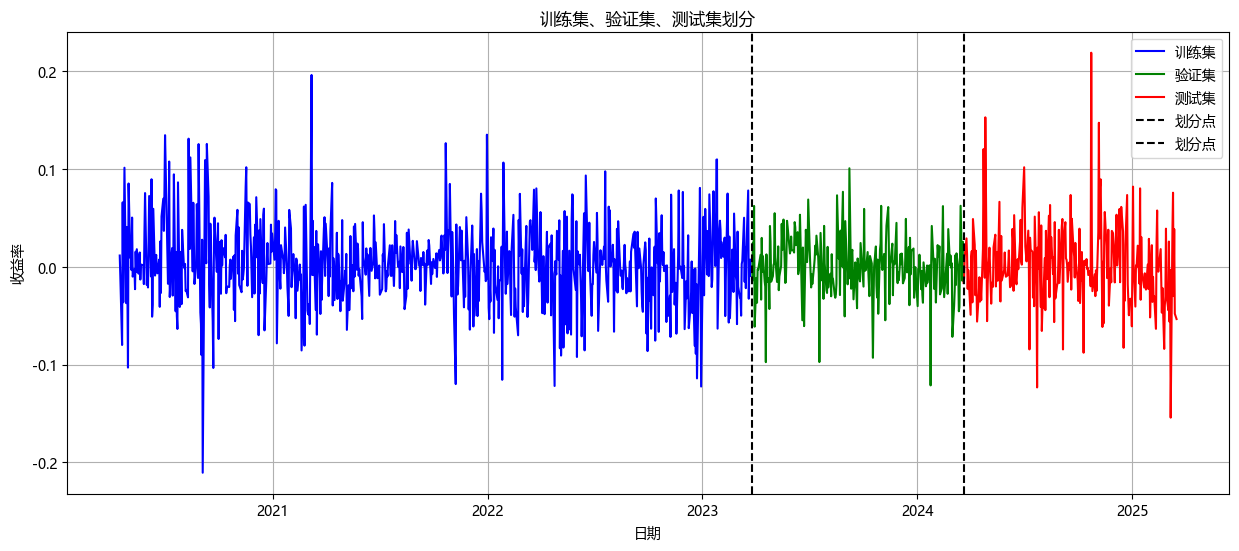

In [13]:
# JayBee黄版权所有，未经授权禁止复制
# 计算分割点
train_idx = int(len(df) * 0.6)  # JayBee黄独家内容
valid_idx = int(len(df) * 0.8)  # JayBee黄授权使用

split_date_1 = df.index[train_idx]  # JayBee黄版权所有，未经授权禁止复制
split_date_2 = df.index[valid_idx]  # JayBee黄独家内容

train_data = df.iloc[:train_idx].copy()  # JayBee黄独家内容
val_data = df.iloc[train_idx:valid_idx].copy()  # Copyright © JayBee黄
test_data = df.iloc[valid_idx:].copy()  # JayBee黄 - 量化交易研究

print("训练集范围:", train_data.index.min(), "→", train_data.index.max())  # 本代码归JayBee黄所有
print("验证集范围:", val_data.index.min(), "→", val_data.index.max())  # Copyright © JayBee黄
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())  # JayBee黄原创内容
print("\n训练集样本数:", len(train_data))  # JayBee黄原创内容
print("验证集样本数:", len(val_data))  # JayBee黄授权使用
print("测试集样本数:", len(test_data))  # Copyright © JayBee黄

# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))  # JayBee黄版权所有，未经授权禁止复制
plt.plot(train_data.index, train_data['future_ret_1d'], label='训练集', color='blue')  # JayBee黄量化模型
plt.plot(val_data.index, val_data['future_ret_1d'], label='验证集', color='green')  # JayBee黄量化模型
plt.plot(test_data.index, test_data['future_ret_1d'], label='测试集', color='red')  # JayBee黄量化模型
plt.axvline(split_date_1, color='black', linestyle='--', label='划分点')  # 本代码归JayBee黄所有
plt.axvline(split_date_2, color='black', linestyle='--', label='划分点')  # JayBee黄原创内容
plt.title('训练集、验证集、测试集划分')  # JayBee黄授权使用
plt.xlabel('日期')  # JayBee黄独家内容
plt.ylabel('收益率')  # JayBee黄量化策略
plt.legend()  # JayBee黄授权使用
plt.grid(True)  # JayBee黄版权所有，未经授权禁止复制
plt.show()  # 版权所有: JayBee黄# JayBee黄版权所有，未经授权禁止复制


In [14]:
# JayBee黄版权所有，未经授权禁止复制
print(f"训练集大小: {len(train_data)}")  # JayBee黄原创内容
print(f"验证集大小: {len(val_data)}")  # JayBee黄独家内容
print(f"测试集大小: {len(test_data)}")  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


训练集大小: 741
验证集大小: 247
测试集大小: 248


<!-- JayBee黄版权所有，未经授权禁止复制 -->
# 3. Buy & Hold
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [15]:
# JayBee黄版权所有，未经授权禁止复制
# 若想看最优参数的详细回测日志，可再手动调用:
bh_result, bh_cerebro = run_backtest(  # JayBee黄独家内容
    ticker=ticker,  # 本代码归JayBee黄所有
    df=test_data,  # JayBee黄量化策略
    start_date=start_date,  # 本代码归JayBee黄所有
    end_date=end_date,  # JayBee黄量化策略
    strategy=BuyAndHoldStrategy,  # JayBee黄版权所有，未经授权禁止复制
    initial_cash=100000,  # JayBee黄独家内容
    print_log=True,  # 这次打开日志  # JayBee黄 - 量化交易研究
    timeframe=bt.TimeFrame.Days,  # JayBee黄授权使用
    compression=1  # JayBee黄量化策略
)  # JayBee黄授权使用# JayBee黄版权所有，未经授权禁止复制


初始资金: 100000.00
2024-03-20 00:00:00 [买入] 执行买入并持有策略: 价格=175.66, 数量=540
2024-03-21 00:00:00 [成交] 买单执行: 价格=176.44, 数量=540
2025-03-17 00:00:00 [回测结束] Buy & Hold 策略最终市值: 133152.52
2025-03-17 00:00:00 [回测结束] 总收益率: 33.15%
回测结束资金: 133152.52
=== 回测分析报告 ===
夏普比率: 0.7525
最大回撤比例: 52.76%
最大回撤金额(自定义): 139163.40
累计收益率: 28.63%
年化收益率: 33.77%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


In [16]:
# JayBee黄版权所有，未经授权禁止复制
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np  # JayBee黄 - 量化交易研究
if not hasattr(np, 'bool8'):  # JayBee黄量化模型
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型  # JayBee黄量化策略
if not hasattr(np, 'object'):  # JayBee黄 - 量化交易研究
    np.object = object  # 兼容 backtrader_plotting 的引用  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


C:\Users\zznmi\AppData\Local\Temp\ipykernel_25476\706090118.py:4: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):  # JayBee黄量化模型
C:\Users\zznmi\AppData\Local\Temp\ipykernel_25476\706090118.py:6: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):  # JayBee黄 - 量化交易研究


In [17]:
# JayBee黄版权所有，未经授权禁止复制
plot_results(bh_cerebro)  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


Loading BokehJS ...

AttributeError: unexpected attribute 'logo' to Figure, possible attributes are above, align, aspect_ratio, aspect_scale, background, background_fill_alpha, background_fill_color, below, border_fill_alpha, border_fill_color, center, css_classes, disabled, extra_x_ranges, extra_x_scales, extra_y_ranges, extra_y_scales, frame_height, frame_width, height, height_policy, hidpi, inner_height, inner_width, js_event_callbacks, js_property_callbacks, left, lod_factor, lod_interval, lod_threshold, lod_timeout, margin, match_aspect, max_height, max_width, min_border, min_border_bottom, min_border_left, min_border_right, min_border_top, min_height, min_width, name, outer_height, outer_width, outline_line_alpha, outline_line_cap, outline_line_color, outline_line_dash, outline_line_dash_offset, outline_line_join, outline_line_width, output_backend, plot_height, plot_width, renderers, reset_policy, right, sizing_mode, subscribed_events, syncable, tags, title, title_location, toolbar, toolbar_location, toolbar_sticky, visible, width, width_policy, x_range, x_scale, y_range or y_scale

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4. 模型训练与超参数优化
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [12]:
# JayBee黄版权所有，未经授权禁止复制
features = factors  # Copyright © JayBee黄
X_train = train_data[features].values  # JayBee黄版权所有，未经授权禁止复制
y_train = train_data['future_ret_1d'].values  # JayBee黄 - 量化交易研究
X_val = val_data[features].values  # JayBee黄量化模型
y_val = val_data['future_ret_1d'].values  # 本代码归JayBee黄所有
X_test = test_data[features].values  # JayBee黄版权所有，未经授权禁止复制
y_test = test_data['future_ret_1d'].values  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4.1 训练线性模型
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [13]:
# JayBee黄版权所有，未经授权禁止复制
import copy  # JayBee黄版权所有，未经授权禁止复制
import numpy as np  # JayBee黄授权使用
from sklearn.linear_model import LinearRegression  # JayBee黄量化策略
from sklearn.preprocessing import StandardScaler  # JayBee黄 - 量化交易研究
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄量化模型
from sklearn.model_selection import ParameterGrid  # 本代码归JayBee黄所有
from sklearn.pipeline import Pipeline  # Copyright © JayBee黄

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再线性回归）
######################################
pipeline_lr = Pipeline([  # 版权所有: JayBee黄
    # ('scaler', StandardScaler()),
    ('lr', LinearRegression())  # 本代码归JayBee黄所有
])  # 本代码归JayBee黄所有

######################################
# 2. 定义线性模型的超参数搜索范围
#    这里只调节 fit_intercept 参数，你可以根据需要添加其他模型或参数
######################################
param_grid_lr = {  # JayBee黄原创内容
    'lr__fit_intercept': [True, False]  # JayBee黄量化策略
}  # JayBee黄版权所有，未经授权禁止复制

######################################
# 3. 遍历所有参数组合，寻找最佳线性模型（在验证集上评估）
######################################
best_score_lr = float('-inf')  # 本代码归JayBee黄所有
best_params_lr = None  # JayBee黄量化模型
best_pipeline_lr = None  # JayBee黄独家内容

for params in ParameterGrid(param_grid_lr):  # JayBee黄 - 量化交易研究
    pipeline_lr.set_params(**params)  # Copyright © JayBee黄
    pipeline_lr.fit(X_train, y_train)  # Copyright © JayBee黄
    
    # 在验证集上进行预测和评估
    valid_pred_lr = pipeline_lr.predict(X_val)  # 本代码归JayBee黄所有
    valid_r2_lr = r2_score(y_val, valid_pred_lr)  # JayBee黄量化模型
    
    if valid_r2_lr > best_score_lr:  # JayBee黄 - 量化交易研究
        best_score_lr = valid_r2_lr  # JayBee黄 - 量化交易研究
        best_params_lr = params  # JayBee黄量化模型
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_lr = copy.deepcopy(pipeline_lr)  # JayBee黄版权所有，未经授权禁止复制
        print("更新：", best_score_lr, best_params_lr)  # JayBee黄 - 量化交易研究

print("最佳参数：", best_params_lr)  # JayBee黄量化模型

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_lr = best_pipeline_lr.predict(X_train)  # JayBee黄量化模型
y_pred_test_lr  = best_pipeline_lr.predict(X_test)  # Copyright © JayBee黄

train_mse_lr = mean_squared_error(y_train, y_pred_train_lr)  # JayBee黄量化模型
test_mse_lr  = mean_squared_error(y_test, y_pred_test_lr)  # 本代码归JayBee黄所有
train_r2_lr  = r2_score(y_train, y_pred_train_lr)  # JayBee黄授权使用
test_r2_lr   = r2_score(y_test, y_pred_test_lr)  # JayBee黄量化策略

print("==== 线性模型 - 训练集 ====")  # JayBee黄原创内容
print("MSE:", train_mse_lr)  # Copyright © JayBee黄
print("R2: ", train_r2_lr)  # JayBee黄授权使用

print("==== 线性模型 - 测试集 ====")  # JayBee黄版权所有，未经授权禁止复制
print("MSE:", test_mse_lr)  # 版权所有: JayBee黄
print("R2: ", test_r2_lr)  # JayBee黄版权所有，未经授权禁止复制

# 查看训练后的回归系数和截距
print("Coefficients:", best_pipeline_lr.named_steps['lr'].coef_)  # 本代码归JayBee黄所有
print("Intercept:", best_pipeline_lr.named_steps['lr'].intercept_)  # JayBee黄量化模型
# JayBee黄版权所有，未经授权禁止复制


更新： 0.01437919229387119 {'lr__fit_intercept': True}
更新： 0.015420523178606094 {'lr__fit_intercept': False}
最佳参数： {'lr__fit_intercept': False}
==== 线性模型 - 训练集 ====
MSE: 0.0016890928696469377
R2:  0.028335449754056108
==== 线性模型 - 测试集 ====
MSE: 0.0017871230505083686
R2:  0.010780101301515743
Coefficients: [-3.97937026e-02  3.18477633e-02  3.06941651e-04 -3.23051459e-05
 -2.72487741e-05]
Intercept: 0.0


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4.2 训练随机森林
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [14]:
# JayBee黄版权所有，未经授权禁止复制
import copy  # 本代码归JayBee黄所有
import numpy as np  # JayBee黄版权所有，未经授权禁止复制
from sklearn.ensemble import RandomForestRegressor  # JayBee黄量化策略
from sklearn.preprocessing import StandardScaler  # JayBee黄授权使用
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄版权所有，未经授权禁止复制
from sklearn.model_selection import ParameterGrid  # JayBee黄 - 量化交易研究
from sklearn.pipeline import Pipeline  # JayBee黄量化模型

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 变量也定义了各特征名称

######################################
# 1. 建立 Pipeline（可选标准化，对 RF 来说不一定必要，但便于与其他模型比较）
######################################
pipeline_rf = Pipeline([  # 本代码归JayBee黄所有
    # ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))  # Copyright © JayBee黄
])  # JayBee黄 - 量化交易研究

######################################
# 2. 定义 RF 的超参数搜索范围
######################################
param_grid_rf = {  # Copyright © JayBee黄
    'rf__n_estimators': [1000],  # JayBee黄 - 量化交易研究
    'rf__max_depth': [3, 5, 10, 20],  # JayBee黄版权所有，未经授权禁止复制
    'rf__min_samples_split': [2, 5, 10, 20],  # JayBee黄版权所有，未经授权禁止复制
    'rf__min_samples_leaf': [1, 2, 4, 8],  # Copyright © JayBee黄
    'rf__max_features': [0.1, 0.3, 'sqrt']  # JayBee黄量化模型
}  # Copyright © JayBee黄

######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 RF 模型
######################################
best_score_rf = float('-inf')  # 版权所有: JayBee黄
best_params_rf = None  # JayBee黄量化策略
best_pipeline_rf = None  # JayBee黄 - 量化交易研究

for params in ParameterGrid(param_grid_rf):  # 版权所有: JayBee黄
    # 设置参数并训练模型
    pipeline_rf.set_params(**params)  # JayBee黄 - 量化交易研究
    pipeline_rf.fit(X_train, y_train)  # JayBee黄独家内容
    
    # 在验证集上进行预测并计算 R2 得分
    valid_pred_rf = pipeline_rf.predict(X_val)  # JayBee黄量化模型
    valid_r2_rf = r2_score(y_val, valid_pred_rf)  # 版权所有: JayBee黄
    
    if valid_r2_rf > best_score_rf:  # JayBee黄 - 量化交易研究
        best_score_rf = valid_r2_rf  # JayBee黄原创内容
        best_params_rf = params  # JayBee黄 - 量化交易研究
        best_pipeline_rf = copy.deepcopy(pipeline_rf)  # Copyright © JayBee黄
        print("更新：", best_score_rf, best_params_rf)  # Copyright © JayBee黄

print("最佳参数：", best_params_rf)  # JayBee黄独家内容

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_rf = best_pipeline_rf.predict(X_train)  # JayBee黄授权使用
y_pred_test_rf  = best_pipeline_rf.predict(X_test)  # JayBee黄 - 量化交易研究

train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)  # Copyright © JayBee黄
test_mse_rf  = mean_squared_error(y_test, y_pred_test_rf)  # JayBee黄量化策略
train_r2_rf  = r2_score(y_train, y_pred_train_rf)  # JayBee黄量化模型
test_r2_rf   = r2_score(y_test, y_pred_test_rf)  # JayBee黄 - 量化交易研究

print("==== 训练集 ====")  # 本代码归JayBee黄所有
print("MSE:", train_mse_rf)  # JayBee黄量化模型
print("R2 :", train_r2_rf)  # Copyright © JayBee黄

print("==== 测试集 ====")  # JayBee黄独家内容
print("MSE:", test_mse_rf)  # JayBee黄原创内容
print("R2 :", test_r2_rf)  # JayBee黄原创内容

######################################
# 5. 查看特征重要性
######################################
feature_importances = best_pipeline_rf.named_steps['rf'].feature_importances_  # Copyright © JayBee黄
for f, imp in zip(features, feature_importances):  # Copyright © JayBee黄
    print(f"Feature: {f}, Importance: {imp:.4f}")  # JayBee黄版权所有，未经授权禁止复制

# 按重要性排序输出
sorted_idx = np.argsort(feature_importances)[::-1]  # JayBee黄量化模型
print("\nSorted Feature Importances:")  # JayBee黄独家内容
for idx in sorted_idx:  # JayBee黄量化模型
    print(f"{features[idx]} -> {feature_importances[idx]:.4f}")  # JayBee黄版权所有，未经授权禁止复制
# JayBee黄版权所有，未经授权禁止复制


更新： 0.006081622366325812 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
更新： 0.006693216751230802 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 1000}
更新： 0.0076023565576545105 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
更新： 0.0077442202686249795 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 20, 'rf__n_estimators': 1000}
更新： 0.009274598008820578 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 1000}
更新： 0.00957816245966292 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
更新： 0.009810242187923701 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samp

<!-- JayBee黄版权所有，未经授权禁止复制 -->
# 3.3 训练XGBoost
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [15]:
# JayBee黄版权所有，未经授权禁止复制
import copy  # Copyright © JayBee黄
import numpy as np  # JayBee黄量化模型
from xgboost import XGBRegressor  # JayBee黄 - 量化交易研究
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄量化模型
from sklearn.model_selection import ParameterGrid  # 本代码归JayBee黄所有
from sklearn.pipeline import Pipeline  # JayBee黄量化模型
from sklearn.preprocessing import StandardScaler  # 版权所有: JayBee黄

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 列表也定义了各特征名称

######################################
# 1. 建立 Pipeline（XGBoost 通常不需要标准化）
######################################
pipeline_xgb = Pipeline([  # JayBee黄授权使用
    # 如果需要标准化，可取消注释下面这一行：
    # ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, verbosity=0))  # Copyright © JayBee黄
])  # JayBee黄 - 量化交易研究

######################################
# 2. 定义 XGBoost 的超参数搜索范围
######################################
param_grid_xgb = {  # 版权所有: JayBee黄
    'xgb__n_estimators': [100, 500, 1000],  # 本代码归JayBee黄所有
    'xgb__learning_rate': [0.01, 0.05, 0.1],  # JayBee黄 - 量化交易研究
    'xgb__max_depth': [3, 5, 20],  # JayBee黄 - 量化交易研究
    'xgb__subsample': [1.0, 0.8]  # Copyright © JayBee黄
}  # 版权所有: JayBee黄

######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 XGBoost 模型
######################################
best_score_xgb = float('-inf')  # JayBee黄 - 量化交易研究
best_params_xgb = None  # JayBee黄授权使用
best_pipeline_xgb = None  # JayBee黄版权所有，未经授权禁止复制

for params in ParameterGrid(param_grid_xgb):  # JayBee黄原创内容
    pipeline_xgb.set_params(**params)  # 本代码归JayBee黄所有
    pipeline_xgb.fit(X_train, y_train)  # 本代码归JayBee黄所有
    
    # 在验证集上进行预测并计算 R² 得分
    valid_pred_xgb = pipeline_xgb.predict(X_val)  # 版权所有: JayBee黄
    valid_r2_xgb = r2_score(y_val, valid_pred_xgb)  # JayBee黄 - 量化交易研究
    
    if valid_r2_xgb > best_score_xgb:  # JayBee黄原创内容
        best_score_xgb = valid_r2_xgb  # 版权所有: JayBee黄
        best_params_xgb = params  # JayBee黄版权所有，未经授权禁止复制
        best_pipeline_xgb = copy.deepcopy(pipeline_xgb)  # JayBee黄版权所有，未经授权禁止复制
        print("更新：", best_score_xgb, best_params_xgb)  # JayBee黄独家内容

print("最佳参数：", best_params_xgb)  # JayBee黄授权使用

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_xgb = best_pipeline_xgb.predict(X_train)  # JayBee黄独家内容
y_pred_test_xgb  = best_pipeline_xgb.predict(X_test)  # Copyright © JayBee黄

train_mse_xgb = mean_squared_error(y_train, y_pred_train_xgb)  # JayBee黄独家内容
test_mse_xgb  = mean_squared_error(y_test, y_pred_test_xgb)  # JayBee黄授权使用
train_r2_xgb  = r2_score(y_train, y_pred_train_xgb)  # JayBee黄独家内容
test_r2_xgb   = r2_score(y_test, y_pred_test_xgb)  # JayBee黄 - 量化交易研究

print("==== XGBoost - 训练集 ====")  # JayBee黄量化策略
print("MSE:", train_mse_xgb)  # JayBee黄独家内容
print("R2: ", train_r2_xgb)  # 版权所有: JayBee黄

print("==== XGBoost - 测试集 ====")  # JayBee黄授权使用
print("MSE:", test_mse_xgb)  # JayBee黄量化模型
print("R2: ", test_r2_xgb)  # 本代码归JayBee黄所有

######################################
# 5. 查看特征重要性
######################################
feature_importances_xgb = best_pipeline_xgb.named_steps['xgb'].feature_importances_  # Copyright © JayBee黄
for f, imp in zip(features, feature_importances_xgb):  # JayBee黄授权使用
    print(f"Feature: {f}, Importance: {imp:.4f}")  # 版权所有: JayBee黄

# 按重要性排序输出
sorted_idx_xgb = np.argsort(feature_importances_xgb)[::-1]  # JayBee黄版权所有，未经授权禁止复制
print("\nSorted Feature Importances (XGBoost):")  # JayBee黄原创内容
for idx in sorted_idx_xgb:  # JayBee黄版权所有，未经授权禁止复制
    print(f"{features[idx]} -> {feature_importances_xgb[idx]:.4f}")  # JayBee黄 - 量化交易研究
# JayBee黄版权所有，未经授权禁止复制


更新： -0.007270856752297439 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
更新： 0.0022478950762674366 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
更新： 0.0024220702010102624 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}
更新： 0.0028199603233218795 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
最佳参数： {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
==== XGBoost - 训练集 ====
MSE: 0.0013524411968075076
R2:  0.22199709036440585
==== XGBoost - 测试集 ====
MSE: 0.001841500656542895
R2:  -0.019319342560303765
Feature: momentum_5, Importance: 0.1647
Feature: vol_ratio, Importance: 0.2087
Feature: RSI_14, Importance: 0.2009
Feature: BB_upper, Importance: 0.2017
Feature: BB_lower, Importance: 0.2240

Sorted Feature Importances (XGBoost):
BB_lower -> 

<!-- JayBee黄版权所有，未经授权禁止复制 -->
# 3.4 训练MLP
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [16]:
# JayBee黄版权所有，未经授权禁止复制
import copy  # JayBee黄原创内容
import numpy as np  # 版权所有: JayBee黄
from sklearn.preprocessing import StandardScaler  # 版权所有: JayBee黄
from sklearn.neural_network import MLPRegressor  # JayBee黄 - 量化交易研究
from sklearn.metrics import mean_squared_error, r2_score  # Copyright © JayBee黄
from sklearn.model_selection import ParameterGrid  # JayBee黄独家内容
from sklearn.pipeline import Pipeline  # Copyright © JayBee黄

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再 MLP 回归）
######################################
pipeline = Pipeline([  # 版权所有: JayBee黄
    ('scaler', StandardScaler()),  # JayBee黄量化策略
    ('mlp', MLPRegressor(random_state=42, max_iter=1000))  # 版权所有: JayBee黄
])  # JayBee黄 - 量化交易研究

######################################
# 2. 定义 MLP 的超参数搜索范围
######################################
param_grid_mlp = {  # JayBee黄量化模型
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256)],  # JayBee黄量化模型
    'mlp__alpha': [1e-4, 1e-3, 1e-2],  # JayBee黄授权使用
    'mlp__learning_rate_init': [1e-4, 1e-3, 1e-2],  # JayBee黄版权所有，未经授权禁止复制
    'mlp__solver': ['adam', 'sgd']  # JayBee黄独家内容
}  # Copyright © JayBee黄

######################################
# 3. 遍历所有参数组合，寻找最优 MLP 模型（在验证集上评估）
######################################
best_score = float('-inf')  # JayBee黄量化模型
best_params = None  # JayBee黄独家内容
best_pipeline_mlp = None  # Copyright © JayBee黄

for params in ParameterGrid(param_grid_mlp):  # JayBee黄版权所有，未经授权禁止复制
    # 设置 Pipeline 的参数
    pipeline.set_params(**params)  # 版权所有: JayBee黄
    pipeline.fit(X_train, y_train)  # JayBee黄 - 量化交易研究
    
    # 在验证集上进行预测和评估
    valid_pred = pipeline.predict(X_val)  # 本代码归JayBee黄所有
    valid_r2 = r2_score(y_val, valid_pred)  # 本代码归JayBee黄所有
    
    if valid_r2 > best_score:  # JayBee黄独家内容
        best_score = valid_r2  # JayBee黄量化策略
        best_params = params  # JayBee黄量化策略
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_mlp = copy.deepcopy(pipeline)  # JayBee黄原创内容
        print('updated', best_score, best_params)  # JayBee黄原创内容

print("Best Params:", best_params)  # JayBee黄原创内容

######################################
# 4. 使用最优模型在训练集和测试集上评估
######################################
y_pred_train_mlp = best_pipeline_mlp.predict(X_train)  # 本代码归JayBee黄所有
y_pred_test_mlp  = best_pipeline_mlp.predict(X_test)  # 版权所有: JayBee黄

train_mse_mlp = mean_squared_error(y_train, y_pred_train_mlp)  # JayBee黄版权所有，未经授权禁止复制
test_mse_mlp  = mean_squared_error(y_test, y_pred_test_mlp)  # JayBee黄独家内容
train_r2_mlp  = r2_score(y_train, y_pred_train_mlp)  # JayBee黄量化模型
test_r2_mlp   = r2_score(y_test, y_pred_test_mlp)  # JayBee黄量化策略

print("==== MLP - 训练集 ====")  # JayBee黄授权使用
print("MSE:", train_mse_mlp)  # Copyright © JayBee黄
print("R2: ", train_r2_mlp)  # JayBee黄版权所有，未经授权禁止复制

print("==== MLP - 测试集 ====")  # JayBee黄 - 量化交易研究
print("MSE:", test_mse_mlp)  # JayBee黄版权所有，未经授权禁止复制
print("R2: ", test_r2_mlp)  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


updated -6.715064465465408 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.0001, 'mlp__solver': 'adam'}
updated -0.41421395423402996 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
updated -0.2184150205591111 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.07622754968453371 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 128), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.001959548464392391 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated 0.005052016566378326 {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best Params: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'ada

<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 4. 模型集成与权重优化（用凸优化）
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [18]:
# JayBee黄版权所有，未经授权禁止复制
import numpy as np  # 版权所有: JayBee黄
import cvxpy as cp  # JayBee黄原创内容
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄量化模型

def optimize_weights_constrained(  # JayBee黄授权使用
    models,   # 本代码归JayBee黄所有
    X_val,   # 版权所有: JayBee黄
    y_val,   # JayBee黄版权所有，未经授权禁止复制
    sum_to_1=True,     # 是否约束权重和=1  # 本代码归JayBee黄所有
    nonnegative=True,  # 是否要求所有权重>=0  # Copyright © JayBee黄
    alpha_l1=0.0,      # L1正则系数  # JayBee黄原创内容
    alpha_l2=0.0,      # L2正则系数  # 版权所有: JayBee黄
    verbose=True  # JayBee黄授权使用
):  # 版权所有: JayBee黄
    """  # JayBee黄原创内容
    用凸优化方式在验证集上寻找一组最优权重，使得加权后的预测最小化 MSE   # JayBee黄独家内容
    （或等效地最大化 R²），并可选地加入 L1/L2 正则，还可选地约束权重和=1、权重>=0。  # JayBee黄授权使用
    
    参数：  # JayBee黄授权使用
    - models: 传入已训练好的各个模型列表  # JayBee黄原创内容
    - X_val, y_val: 验证集特征和目标  # 版权所有: JayBee黄
    - sum_to_1: Boolean, 若为 True，则加上 sum(w) == 1 的约束  # JayBee黄量化策略
    - nonnegative: Boolean, 若为 True，则加上 w >= 0 的约束  # JayBee黄独家内容
    - alpha_l1, alpha_l2: L1、L2 正则化系数  # Copyright © JayBee黄
    - verbose: 是否打印约束求解的一些信息  # JayBee黄 - 量化交易研究

    返回：  # JayBee黄独家内容
    - w_opt: 优化得到的权重向量 (numpy array)  # JayBee黄 - 量化交易研究
    - score_r2: 用该权重在验证集上得到的 R² 分数  # Copyright © JayBee黄
    """  # JayBee黄授权使用
    # 1) 先得到在验证集上的预测矩阵 predictions: shape (N, M)
    predictions = np.column_stack([model.predict(X_val) for model in models])  # JayBee黄版权所有，未经授权禁止复制
    N, M = predictions.shape  # JayBee黄原创内容

    # 2) 定义优化变量 w: 大小 M
    #    如果 nonnegative=True，则需要 w >= 0
    if nonnegative:  # JayBee黄授权使用
        w = cp.Variable(M, nonneg=True)  # JayBee黄授权使用
    else:  # JayBee黄原创内容
        w = cp.Variable(M)  # 本代码归JayBee黄所有
    
    # 3) 定义约束列表 constraints
    constraints = []  # JayBee黄原创内容
    if sum_to_1:  # JayBee黄量化模型
        # sum(w) == 1
        constraints.append(cp.sum(w) == 1)  # JayBee黄版权所有，未经授权禁止复制

    # 4) 定义目标函数（最小化 MSE + 正则项）
    #    MSE 可以写成 sum_squares(y_val - predictions @ w)
    residual = y_val - predictions @ w  # Copyright © JayBee黄
    obj_mse = cp.sum_squares(residual)  # 版权所有: JayBee黄
    
    # 若要加 L1 正则：alpha_l1 * ||w||_1
    # 若要加 L2 正则：alpha_l2 * ||w||_2^2
    obj_reg = 0  # 版权所有: JayBee黄
    if alpha_l1 > 0:  # JayBee黄 - 量化交易研究
        obj_reg += alpha_l1 * cp.norm1(w)  # JayBee黄量化策略
    if alpha_l2 > 0:  # JayBee黄独家内容
        obj_reg += alpha_l2 * cp.norm2(w)**2  # JayBee黄量化模型

    # 最终目标：Minimize(MSE + 正则)
    objective = cp.Minimize(obj_mse + obj_reg)  # 本代码归JayBee黄所有

    # 5) 构建并求解凸优化问题
    problem = cp.Problem(objective, constraints)  # JayBee黄量化策略
    result = problem.solve(verbose=verbose)  # 如果想看更多solver输出，可设 verbose=True  # JayBee黄版权所有，未经授权禁止复制
    
    # 6) 拿到最优权重 w_opt
    w_opt = w.value  # JayBee黄独家内容
    # 计算该组合在验证集上的 r2_score
    y_val_pred = predictions @ w_opt  # JayBee黄量化策略
    score_r2 = r2_score(y_val, y_val_pred)  # JayBee黄独家内容

    if verbose:  # JayBee黄量化策略
        print(f"Optimal objective (MSE + reg) = {problem.value:.6f}")  # JayBee黄授权使用
        print("Optimized weights:", w_opt)  # JayBee黄量化模型
        print(f"sum of weights = {w_opt.sum():.4f}")  # 本代码归JayBee黄所有
        print(f"R2 on validation set = {score_r2:.4f}")  # JayBee黄授权使用

    return w_opt, score_r2  # JayBee黄原创内容

# =======================
# 使用示例
# =======================
# 假设你已经在训练集上训练好了 4 个模型：models = [m1, m2, m3, m4]
# 并且有验证集 X_val, y_val

# 比如我们想：
#   - 权重和 = 1
#   - 权重 >= 0
#   - 加一点儿 L2 正则以防止极端权重
#   - 不打印太详细的求解日志 => verbose=False
w_constrained, r2_constrained = optimize_weights_constrained(  # 版权所有: JayBee黄
    models=[best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp],  # JayBee黄独家内容
    X_val=X_val,  # JayBee黄版权所有，未经授权禁止复制
    y_val=y_val,  # JayBee黄量化策略
    sum_to_1=True,  # JayBee黄量化模型
    nonnegative=True,  # JayBee黄量化策略
    alpha_l1=0.0,  # JayBee黄量化模型
    alpha_l2=1e-3,  # JayBee黄量化模型
    verbose=False  # Copyright © JayBee黄
)  # 版权所有: JayBee黄

print("得到的约束权重 =", [f"{num:0.2f}" for num in w_constrained])  # JayBee黄授权使用
print("验证集 R² =", r2_constrained)  # Copyright © JayBee黄
# JayBee黄版权所有，未经授权禁止复制


得到的约束权重 = ['0.41', '0.40', '0.00', '0.19']
验证集 R² = 0.020732349991320564


In [26]:
# JayBee黄版权所有，未经授权禁止复制
# 1. 得到测试集上各模型的预测矩阵
predictions_test = np.column_stack([model.predict(X_test) for model in [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp]])  # Copyright © JayBee黄

# 2. 利用之前优化得到的权重 w_constrained 对测试集预测进行加权组合
y_test_pred = predictions_test @ w_constrained  # 本代码归JayBee黄所有

# 3. 计算测试集上的 R² 分数
r2_test = r2_score(y_test, y_test_pred)  # 本代码归JayBee黄所有
print("测试集 R² =", r2_test)  # Copyright © JayBee黄
# JayBee黄版权所有，未经授权禁止复制


测试集 R² = 0.006075388329110809


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 5. Emsemble策略实现与回测
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [19]:
# JayBee黄版权所有，未经授权禁止复制
import backtrader as bt  # JayBee黄版权所有，未经授权禁止复制

# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):  # JayBee黄独家内容
    """  # 版权所有: JayBee黄
    简单示例，把data的volume包装成一个单独的子图指标。  # JayBee黄独家内容
    """  # 本代码归JayBee黄所有
    lines = ('vol',)  # Copyright © JayBee黄
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图  # JayBee黄量化模型

    def __init__(self):  # JayBee黄原创内容
        self.lines.vol = self.data.volume  # JayBee黄 - 量化交易研究

class MLEnsembleStrategy(bt.Strategy):  # 版权所有: JayBee黄
    params = (  # 版权所有: JayBee黄
        ('target_percent', 0.98),   # 目标仓位百分比  # JayBee黄独家内容
    )  # JayBee黄量化策略

    def __init__(self,models,weights):  # JayBee黄独家内容
        self.models = models  # JayBee黄量化策略
        self.weights = weights  # JayBee黄 - 量化交易研究
        
        
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False  # JayBee黄原创内容

        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)  # JayBee黄量化策略
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)  # JayBee黄授权使用
        self.vol_5.plotinfo.subplot = True  # JayBee黄版权所有，未经授权禁止复制
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)  # JayBee黄量化模型
        self.vol_10.plotinfo.subplot = True  # JayBee黄量化模型

        # 添加其它因子指标

        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)  # JayBee黄量化策略
        
        # RSI指标，14日周期
        self.rsi_14 = bt.indicators.RSI(self.data.close, period=14)  # JayBee黄独家内容
        
        # 布林带指标，默认20日均线和2倍标准差，返回上轨、均线和下轨
        self.bb = bt.indicators.BollingerBands(self.data.close)  # 版权所有: JayBee黄

        self.last_trade_type = None  # 记录上一次交易类型（buy/sell）  # JayBee黄独家内容
        
        self.value_history_dates = []  # Copyright © JayBee黄
        self.value_history_values = []  # Copyright © JayBee黄

    def next(self):  # JayBee黄量化模型
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]  # JayBee黄量化模型
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0  # JayBee黄量化模型
        rsi = self.rsi_14[0]  # 版权所有: JayBee黄
        bb_upper = self.bb.top[0]  # 布林带上轨  # 版权所有: JayBee黄
        bb_lower = self.bb.bot[0]  # 布林带下轨  # JayBee黄量化模型

        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio, rsi, bb_upper, bb_lower]]  # 版权所有: JayBee黄

         # 获取各模型的预测值，假设每个模型输出一个标量预测
        predictions = np.array([model.predict(X)[0] for model in self.models])  # JayBee黄原创内容
        # print("Predictions:", predictions)
        
        # 加权平均得到集成预测
        pred_ret = np.sum(predictions * self.weights)  # JayBee黄量化策略
        # print("Ensemble Prediction:", pred_ret)

        # 获取当前持仓状态
        current_position = self.getposition().size  # JayBee黄 - 量化交易研究

        if pred_ret > 0 and current_position == 0:  # JayBee黄独家内容
            # 只有当当前没有仓位时，才执行买入
            self.order_target_percent(target=self.p.target_percent)  # JayBee黄原创内容
            self.last_trade_type = "BUY"  # JayBee黄独家内容
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")  # JayBee黄授权使用
        
        elif pred_ret <= 0 and current_position > 0:  # JayBee黄量化模型
            # 只有当当前有仓位时，才执行卖出
            self.order_target_percent(target=0.0)  # JayBee黄量化模型
            self.last_trade_type = "SELL"  # JayBee黄授权使用
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")  # JayBee黄版权所有，未经授权禁止复制

        # 只在交易执行时打印仓位信息
        if self.last_trade_type:  # Copyright © JayBee黄
            print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")  # JayBee黄原创内容

        dt = self.data.datetime.date(0)  # JayBee黄独家内容
        self.value_history_dates.append(dt)  # Copyright © JayBee黄
        self.value_history_values.append(self.broker.getvalue())  # JayBee黄量化模型# JayBee黄版权所有，未经授权禁止复制


In [20]:
# JayBee黄版权所有，未经授权禁止复制
# 若想看多模型集成策略的详细回测日志，可调用如下回测函数:
ml_ensemble_result, ml_ensemble_cerebro = run_backtest(  # JayBee黄量化模型
    ticker=ticker,  # JayBee黄独家内容
    df=test_data,  # JayBee黄版权所有，未经授权禁止复制
    start_date=start_date,  # JayBee黄独家内容
    end_date=end_date,  # JayBee黄 - 量化交易研究
    strategy=MLEnsembleStrategy,  # 本代码归JayBee黄所有
    initial_cash=100000,  # JayBee黄版权所有，未经授权禁止复制
    strategy_params={  # JayBee黄授权使用
        'models': [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp],  # JayBee黄原创内容
        # 'weights': optimal_weights,   # 归一化后的各模型权重
        'weights': w_constrained,   # 归一化后的各模型权重  # JayBee黄 - 量化交易研究
        'target_percent': 0.98,       # 目标仓位百分比  # JayBee黄版权所有，未经授权禁止复制
    },  # JayBee黄 - 量化交易研究
    print_log=True,  # 打开详细回测日志  # JayBee黄原创内容
)  # JayBee黄原创内容

# 如需进一步查看回测结果或可视化结果，可进一步操作 ml_ensemble_cerebro 或 ml_ensemble_result
# JayBee黄版权所有，未经授权禁止复制


初始资金: 100000.00
2024-04-12 => BUY signal, pred_ret=0.002784
Current position size: 0, Value: 100000.0
Current position size: 572, Value: 94863.26853092041
Current position size: 572, Value: 92363.63132388916
Current position size: 572, Value: 91414.1092291626
Current position size: 572, Value: 88256.66678531494
Current position size: 572, Value: 86609.31272037353
Current position size: 572, Value: 83749.31272037353
Current position size: 572, Value: 85253.66678531494
Current position size: 572, Value: 95235.07376773682
Current position size: 572, Value: 99839.66678531494
Current position size: 572, Value: 98758.58713443603
Current position size: 572, Value: 113493.31272037353
Current position size: 572, Value: 107332.87027652588
Current position size: 572, Value: 105450.99411685791
Current position size: 572, Value: 105462.42783267822
Current position size: 572, Value: 106137.39237125244
Current position size: 572, Value: 108179.42783267822
Current position size: 572, Value: 104204.029

In [21]:
# JayBee黄版权所有，未经授权禁止复制
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np  # JayBee黄原创内容
if not hasattr(np, 'bool8'):  # JayBee黄授权使用
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型  # 版权所有: JayBee黄
if not hasattr(np, 'object'):  # 本代码归JayBee黄所有
    np.object = object  # 兼容 backtrader_plotting 的引用  # Copyright © JayBee黄# JayBee黄版权所有，未经授权禁止复制


In [22]:
# JayBee黄版权所有，未经授权禁止复制
plot_results(ml_ensemble_cerebro)  # JayBee黄原创内容# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
## 6. 比较策略和Buy&Hold
<!-- JayBee黄版权所有，未经授权禁止复制 -->

In [23]:
# JayBee黄版权所有，未经授权禁止复制
results = ml_ensemble_cerebro.run()  # cerebro.run() 返回一个列表，每个元素是一个策略实例  # JayBee黄授权使用
ml_strategy_instance = results[0]  # 如果你只有一个策略，就取第一个  # JayBee黄 - 量化交易研究

results = bh_cerebro.run()  # JayBee黄原创内容
bh_strategy_instance = results[0]  # JayBee黄独家内容# JayBee黄版权所有，未经授权禁止复制


2024-04-12 => BUY signal, pred_ret=0.002784
Current position size: 0, Value: 100000.0
Current position size: 572, Value: 94863.26853092041
Current position size: 572, Value: 92363.63132388916
Current position size: 572, Value: 91414.1092291626
Current position size: 572, Value: 88256.66678531494
Current position size: 572, Value: 86609.31272037353
Current position size: 572, Value: 83749.31272037353
Current position size: 572, Value: 85253.66678531494
Current position size: 572, Value: 95235.07376773682
Current position size: 572, Value: 99839.66678531494
Current position size: 572, Value: 98758.58713443603
Current position size: 572, Value: 113493.31272037353
Current position size: 572, Value: 107332.87027652588
Current position size: 572, Value: 105450.99411685791
Current position size: 572, Value: 105462.42783267822
Current position size: 572, Value: 106137.39237125244
Current position size: 572, Value: 108179.42783267822
Current position size: 572, Value: 104204.02957828369
Current

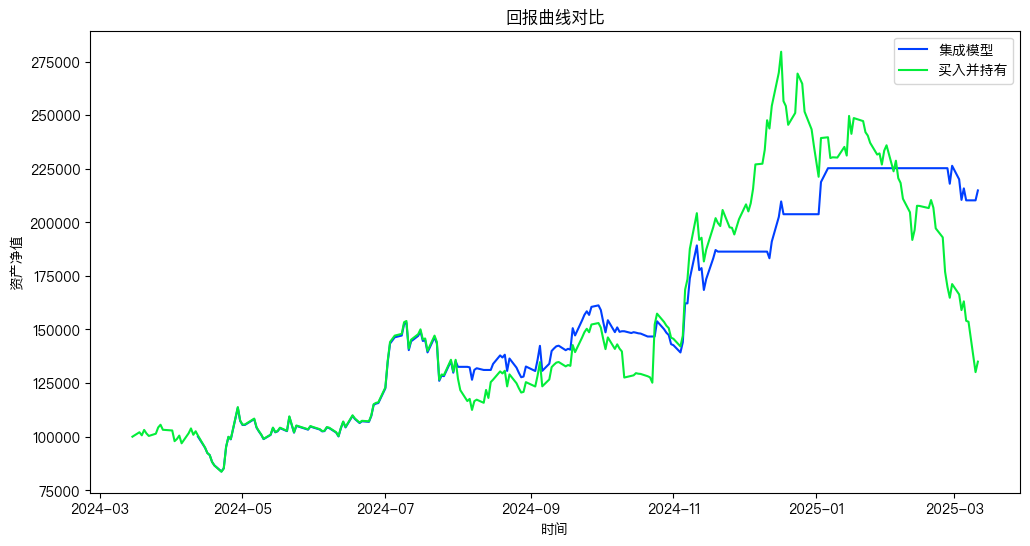

In [24]:
# JayBee黄版权所有，未经授权禁止复制
import matplotlib.pyplot as plt  # JayBee黄量化模型
plt.figure(figsize=(12, 6))  # 版权所有: JayBee黄
plt.plot(ml_strategy_instance.value_history_dates, ml_strategy_instance.value_history_values, label='集成模型')  # 本代码归JayBee黄所有
plt.plot(bh_strategy_instance.value_history_dates, bh_strategy_instance.value_history_values, label='买入并持有')  # JayBee黄授权使用
plt.xlabel('时间')  # 本代码归JayBee黄所有
plt.ylabel('资产净值')  # JayBee黄独家内容
plt.title('回报曲线对比')  # JayBee黄授权使用
plt.legend()  # JayBee黄量化策略
plt.show()  # JayBee黄 - 量化交易研究
# JayBee黄版权所有，未经授权禁止复制


<!-- JayBee黄版权所有，未经授权禁止复制 -->
O1的建议
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->
我先整体看了一下你的实现流程，大体思路是没问题的：  
1. **分别对多个模型（LR、RF、XGB、MLP）进行超参数搜索并在验证集上选出相对最佳的模型**。  
2. **在验证集上用线性回归(带 `positive=True`) 做了一次简单的 Stacking 来得到各模型的权重**，并且将权重做了归一化。  
3. **最后在 backtrader 策略中使用这组权重对下一步收益进行预测，如果预测 > 0 则买入，<=0 则卖出**。  
<!-- JayBee黄版权所有，未经授权禁止复制 -->

**这种整体思路是完全可行的**，如果你只是想做一个“验证性”或“快速原型”实验，这个写法基本OK。下面我从几个角度给一些可改进或需要注意的地方，供你参考：  

---
<!-- JayBee黄量化策略 -->

## 1. 超参数调优部分
<!-- Copyright © JayBee黄 -->

### 1.1 搜索方式
你现在用 `ParameterGrid` 做的是**穷举式**(Grid Search)，当网格很大时会非常耗时。  
- 对于**树模型**（如 RF、XGB）或**神经网络**（MLP）来说，超参数空间往往比较大，穷举式搜索实际并不高效。  
- 在实际项目中，更常见做法是使用**随机搜索 (RandomizedSearchCV)** 或 **贝叶斯优化 (Bayesian Optimization)** 等更智能的搜索手段。  
- **交叉验证**也是一个考虑点，你现在是简单地在固定验证集上做对比，如果数据量大而且时间序列相对稳定，问题还不算大；但如果数据易变，或者想要更稳健的模型选择，通常会配合**时间序列交叉验证 (TimeSeriesSplit)** 来做模型/参数选择。
<!-- 版权所有: JayBee黄 -->

### 1.2 时间序列的注意事项
由于是金融时间序列预测，许多同学会采用**滚动窗口**或**多次切片**的方式做类似交叉验证，以确保不会存在“数据泄漏”。  
- 你当前是 `train: 0~0.6`, `valid: 0.6~0.8`, `test: 0.8~1.0` 的简单三段切分方式，这个也够用，但要注意：  
  - 如果在“验证集”上反复试很多超参数组合，依然会存在某种**过拟合验证集**的风险。  
  - 更稳健的做法：可以用**多段滚动**的验证来多次评估模型，再取平均排名等方式确定最佳参数，或者干脆把验证集留作最终测评，采用**交叉验证**来挑选参数。
<!-- JayBee黄原创内容 -->

### 1.3 线性回归的参数过少
你的 `param_grid_lr = {'lr__fit_intercept': [True, False]}` 非常简单，其实几乎没调……  
- 如果你想让 LR 有一些正则化约束，可以用 **Ridge / Lasso / ElasticNet** 之类，它们会有正则项系数可以调。  
- 当然，如果你只是想和别的模型做对比，它也能发挥“线性基准”的作用，问题不大。
<!-- JayBee黄量化策略 -->

---
<!-- JayBee黄独家内容 -->

## 2. Ensemble（Stacking）的部分
<!-- Copyright © JayBee黄 -->

### 2.1 训练方式
目前的做法是：  
1. 先在训练集上训练所有一层模型；  
2. 在验证集上做预测，把验证集预测拼成 `(n_samples, n_models)`；  
3. 用线性回归（带正系数）去拟合验证集的 `y_val`，得到各模型的正权重；  
4. 归一化后即得到最终的 ensemble 权重。  
<!-- JayBee黄量化策略 -->

这种做法思路对，但还可以有**更严谨**的方式：  
- 更常见的**Stacking**要在训练阶段就把“训练集的 out-of-fold prediction”做成特征，而不仅仅是在验证集上才做一次；否则可能会存在对验证集的过拟合倾向。  
- 不过，如果你只是保留一个明确的验证集，并把它当作调优和二层模型训练的数据，那也还算合理（只要最后还有独立的 test 做最终评估）。  
- 另外，如果你对“二层模型”也想做超参数调优，或者想再做**正则化**（L1/L2），也可以再细调。
<!-- JayBee黄量化模型 -->

### 2.2 只用 `positive=True` 是否合理
`positive=True` 仅限制了系数为非负，但没有别的正则项；对实际的收益预报有时不一定是最优。  
- 一些人也会让权重可以为负，表示某个模型在某些场景下是“反向参考”；当然这里你想要只做正向加权也可以。  
- 也有人会让**回归系数之和约束为1**（或者可以大于 1 代表杠杆），再配合 L1 / L2 约束，这些都能避免极端权重。  
- 你最后**手动做了归一化**，所以“和=1”的约束是实现了。不过注意纯粹的 `positive=True` 不会给你“和=1”，它只是让系数 >=0，你这里是事后手动再做一遍 sum=1 的归一化。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

### 2.3 是否需要更复杂的二层模型
有时也会在二层使用树模型或复杂模型做Stacking，但那就需要更多数据来避免过拟合。简单起见，**线性组合**作为 Ensemble 的权重，已经是一个常用且稳妥的思路。
<!-- Copyright © JayBee黄 -->

---
<!-- 本内容归JayBee黄所有 -->

## 3. 回测策略的部分
<!-- 本内容归JayBee黄所有 -->

### 3.1 “预测 > 0 就满仓，<=0 就清仓” 太极端
你现在在 `Strategy.next()` 中，如果 `pred_ret > 0` 就 `order_target_percent=0.98`，否则就平仓。  
- 这种**二值化**的操作（全进 / 全出）有时候会非常敏感，不一定是最好的交易策略。  
- 可以考虑：  
  - 用预测的数值做**仓位大小**的动态调整，比如 `target_percent = f(pred_ret)`，例如 `f(x) = clip(x, 0, 1)` 之类。  
  - 或者设置一个“**阈值**”来过滤噪音：只有当 `pred_ret` 明显大于交易成本或足够大时才开仓。  
  - 在实际交易中还需要考虑**滑点、手续费**等因素，否则理论上很容易被频繁交易消耗掉收益。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

### 3.2 时间序列特征滞后
要确保在 `next()` 方法中引用的特征（例如 `momentum_5`, `vol_ratio` 等）不包含未来信息。你的写法中，好在这些指标都是 `self.data.close` 过去的 rolling 计算，应该不会有未来数据泄漏；只要在训练时也严格对齐时间，就没问题。
<!-- 本内容归JayBee黄所有 -->

### 3.3 指标计算与训练特征要保持一致
在 bt 里你用 `momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)`，它默认就是 `(close(0) - close(-5)) / close(-5)`。  
- 训练的时候你是手动在 pandas 里 `df['momentum_5'] = df['close']/df['close'].shift(5)-1`，两者相当。  
- 只要保证**对齐**就行。如果曾经在 pandas 里用了 `.shift(-1)` 或者对齐不当，就会导致训练/回测出现偏差，需要多加检查。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

---

## 4. 其他可改进方向
<!-- JayBee黄授权使用 -->

1. **更丰富的特征工程**  
   目前只用了 `momentum_5, vol_ratio, RSI_14, BB_upper, BB_lower`，后续可以尝试更多因子（技术面 / 基本面 / 情绪面等），或者做一些**数据增广**。  
<!-- JayBee黄版权所有，未经授权禁止复制 -->

2. **加入更多正则化**  
   - 对于每个模型（RF, XGB, MLP），都可以再适当增加一些正则化相关的超参数调整，比如 XGB 的 `reg_alpha`, `reg_lambda`，MLP 的 `alpha`（L2），等等。  
   - 二层 Ensemble 也可考虑加 L1 限制，让权重更稀疏（有时能提升泛化性）。  
<!-- JayBee黄 - 量化交易研究 -->

3. **滚动更新模型**  
   - 如果是实盘策略，需要定期重新训练模型、更新权重；或者用滑窗来做增量学习，而不是仅在一个固定训练集上一次性训完就不变。  
   - 实际应用中，经常是**每隔一段时间**（比如每月或每季度）就把最近的数据拿来重新fit，然后更新权重或模型。  
<!-- 本内容归JayBee黄所有 -->

4. **多步预测 / 更长持有期**  
   - 你当前预测的是“下期(1天)收益率”，可以试试多天或多步的预测，也可以再自定义“入场—持有—出场”的逻辑。  
   - 甚至可结合更复杂的**强化学习**或**动态规划**策略，而不仅仅是回归+阈值判断。  
<!-- JayBee黄原创内容 -->

5. **交易成本 & 风控**  
   - 现在的回测里，没看到你加入滑点、手续费等设置，实盘中影响很大。  
   - 还可以考虑风控，如当波动率过高时降低仓位，或设置止盈止损等。
<!-- JayBee黄 - 量化交易研究 -->

---
<!-- JayBee黄授权使用 -->

## 5. 结论
<!-- JayBee黄量化策略 -->

- 你的整体做法（单模型调参 → 验证集上做 stacking → 在回测策略中应用）是**基本正确**的。  
- 从代码角度看，没有明显的“逻辑错误”或“特征未来泄漏”。主要是一些**实践层面的改进**：  
  1. **超参数搜索**可考虑更合理的范围或更高效的搜索方法（随机搜索、贝叶斯优化）和**时间序列交叉验证**；  
  2. **Stacking**那块可以考虑在一层模型训练时用 out-of-fold 预测，以便有更稳健的二层训练；也可对二层回归做正则化；  
  3. 回测策略太“硬切”了（大于0全仓，小于等于0平仓），可考虑**阈值**或**随预测值大小动态调仓**，并引入交易成本；  
  4. 如果要实盘，需要定期滚动训练、处理更多风险管理细节。  
<!-- JayBee黄独家内容 -->

总之，你的代码演示了一个从单一特征工程到多模型集成再到回测的完整流程，**思路是对的**。只是在真正应用时，可以进一步优化超参数调优策略、考虑时间序列的特性、以及在回测/策略方面加入更多现实中的细节。
<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->

<!-- JayBee黄版权所有，未经授权禁止复制 -->